In [9]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [10]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [11]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

In [12]:
df.shape

(60675, 390)

### Transform the Dataset

In [13]:
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset21/data0.csv')

In [14]:
df

gene_name     AC073488.4  AC119427.1  MIR543       MADD  AL356737.2     MAST2  \
RNA1_FPKM         0.0000         0.0     0.0   6.345943         0.0  0.869310   
RNA102_FPKM       0.0000         0.0     0.0   8.482109         0.0  1.497604   
RNA104_FPKM       0.0000         0.0     0.0  10.209322         0.0  1.885831   
RNA108_FPKM       0.0000         0.0     0.0   7.143557         0.0  1.245977   
RNA109_FPKM       0.0000         0.0     0.0   5.671481         0.0  0.994017   
...                  ...         ...     ...        ...         ...       ...   
R_JS037_FPKM      0.0000         0.0     0.0   8.396802         0.0  1.157648   
R_JS038_FPKM      0.1133         0.0     0.0   7.705327         0.0  1.141251   
R_JS039_FPKM      0.0000         0.0     0.0   8.115721         0.0  1.221781   
R_JS040_FPKM      0.0000         0.0     0.0   7.630287         0.0  0.873866   
R_JS041_FPKM      0.0000         0.0     0.0  10.701490         0.0  1.493401   

gene_name      TRBJ2-5    TRBJ2-4  SAA2-SAA4    TRBJ2-3  ...  AC092437.1  \
RNA1_FPKM     6.620190  14.299610        0.0  27.561607  ...    0.303215   
RNA102_FPKM   1.569853   1.507059        0.0   9.228358  ...    0.000000   
RNA104_FPKM   3.085139   7.402744        0.0  16.618730  ...    0.000000   
RNA108_FPKM   3.351034   8.041719        0.0  14.769571  ...    0.000000   
RNA109_FPKM   8.329660  19.191217        0.0  16.319334  ...    0.000000   
...                ...        ...        ...        ...  ...         ...   
R_JS037_FPKM  3.773474  14.492225        0.0  14.787984  ...    0.000000   
R_JS038_FPKM  1.786837  13.722905        0.0  29.756299  ...    0.000000   
R_JS039_FPKM  1.615103   7.754087        0.0  23.735377  ...    0.000000   
R_JS040_FPKM  8.385021  19.320696        0.0  27.928893  ...    0.460856   
R_JS041_FPKM  3.467181  11.650639        0.0  27.173236  ...    0.000000   

gene_name     AC131212.4  Z83836.1      RBM10  PRKCZ-AS1    GALNT9    GABPB2  \
RNA1_FPKM       0.081479  0.000000  18.065813   2.203156  0.000000  3.027988   
RNA102_FPKM     0.000000  0.000000  17.878264   1.969454  0.014690  2.766359   
RNA104_FPKM     0.000000  0.000000  16.252944   1.263376  0.028862  2.665226   
RNA108_FPKM     0.000000  0.000000  15.934811   2.444487  0.000000  2.187239   
RNA109_FPKM     0.000000  0.000000  18.742771   1.066154  0.000000  2.850764   
...                  ...       ...        ...        ...       ...       ...   
R_JS037_FPKM    0.000000  0.000000  13.580158   2.366973  0.026488  4.289500   
R_JS038_FPKM    0.263902  0.000000  13.289845   2.607308  0.000000  2.415953   
R_JS039_FPKM    0.079513  0.000000  15.415710   2.439791  0.007557  3.050911   
R_JS040_FPKM    0.000000  0.049023  15.004002   3.348856  0.023539  2.756612   
R_JS041_FPKM    0.170692  0.000000  19.196550   3.417375  0.064889  3.970303   

gene_name     PLBD1-AS1  RNU6-1090P  AL023882.1  
RNA1_FPKM      0.676363         0.0    0.043794  
RNA102_FPKM    1.150103         0.0    0.623174  
RNA104_FPKM    1.141618         0.0    0.571317  
RNA108_FPKM    2.350972         0.0    0.398958  
RNA109_FPKM    1.965337         0.0    0.396720  
...                 ...         ...         ...  
R_JS037_FPKM   1.091251         0.0    0.499304  
R_JS038_FPKM   0.716444         0.0    0.614656  
R_JS039_FPKM   0.685049         0.0    0.598406  
R_JS040_FPKM   0.491421         0.0    0.798794  
R_JS041_FPKM   0.895655         0.0    1.284474  

[193 rows x 60675 columns]

### Combine with Diagnosis

In [15]:
df = pd.read_csv('../Datasets/Dataset21/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset21/data1.csv')

df.head()

AC073488.4  AC119427.1  MIR543       MADD  AL356737.2     MAST2  \
RNA1_FPKM           0.0         0.0     0.0   6.345943         0.0  0.869310   
RNA102_FPKM         0.0         0.0     0.0   8.482109         0.0  1.497604   
RNA104_FPKM         0.0         0.0     0.0  10.209322         0.0  1.885831   
RNA108_FPKM         0.0         0.0     0.0   7.143557         0.0  1.245977   
RNA109_FPKM         0.0         0.0     0.0   5.671481         0.0  0.994017   

              TRBJ2-5    TRBJ2-4  SAA2-SAA4    TRBJ2-3  ...  AC131212.4  \
RNA1_FPKM    6.620190  14.299610        0.0  27.561607  ...    0.081479   
RNA102_FPKM  1.569853   1.507059        0.0   9.228358  ...    0.000000   
RNA104_FPKM  3.085139   7.402744        0.0  16.618730  ...    0.000000   
RNA108_FPKM  3.351034   8.041719        0.0  14.769571  ...    0.000000   
RNA109_FPKM  8.329660  19.191217        0.0  16.319334  ...    0.000000   

             Z83836.1      RBM10  PRKCZ-AS1    GALNT9    GABPB2  PLBD1-AS1  \
RNA1_FPKM         0.0  18.065813   2.203156  0.000000  3.027988   0.676363   
RNA102_FPKM       0.0  17.878264   1.969454  0.014690  2.766359   1.150103   
RNA104_FPKM       0.0  16.252944   1.263376  0.028862  2.665226   1.141618   
RNA108_FPKM       0.0  15.934811   2.444487  0.000000  2.187239   2.350972   
RNA109_FPKM       0.0  18.742771   1.066154  0.000000  2.850764   1.965337   

             RNU6-1090P  AL023882.1  Diagnosis  
RNA1_FPKM           0.0    0.043794          1  
RNA102_FPKM         0.0    0.623174          2  
RNA104_FPKM         0.0    0.571317          1  
RNA108_FPKM         0.0    0.398958          1  
RNA109_FPKM         0.0    0.396720          0  

[5 rows x 60676 columns]

### Remove Patients who hasn't Diabetic

In [16]:
df = pd.read_csv('../Datasets/Dataset21/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset21/data2.csv")
df.head()

AC073488.4  AC119427.1    MIR543       MADD  AL356737.2  \
RNA1_FPKM           0.0         0.0  0.000000   6.345943         0.0   
RNA102_FPKM         0.0         0.0  0.000000   8.482109         0.0   
RNA104_FPKM         0.0         0.0  0.000000  10.209322         0.0   
RNA108_FPKM         0.0         0.0  0.000000   7.143557         0.0   
RNA110_FPKM         0.0         0.0  0.962816   7.776351         0.0   

                MAST2   TRBJ2-5    TRBJ2-4  SAA2-SAA4    TRBJ2-3  ...  \
RNA1_FPKM    0.869310  6.620190  14.299610        0.0  27.561607  ...   
RNA102_FPKM  1.497604  1.569853   1.507059        0.0   9.228358  ...   
RNA104_FPKM  1.885831  3.085139   7.402744        0.0  16.618730  ...   
RNA108_FPKM  1.245977  3.351034   8.041719        0.0  14.769571  ...   
RNA110_FPKM  1.354624  6.259724  16.526012        0.0  29.125836  ...   

             AC131212.4  Z83836.1      RBM10  PRKCZ-AS1    GALNT9    GABPB2  \
RNA1_FPKM      0.081479       0.0  18.065813   2.203156  0.000000  3.027988   
RNA102_FPKM    0.000000       0.0  17.878264   1.969454  0.014690  2.766359   
RNA104_FPKM    0.000000       0.0  16.252944   1.263376  0.028862  2.665226   
RNA108_FPKM    0.000000       0.0  15.934811   2.444487  0.000000  2.187239   
RNA110_FPKM    0.000000       0.0  27.361029   2.724196  0.036608  1.831605   

             PLBD1-AS1  RNU6-1090P  AL023882.1  Diagnosis  
RNA1_FPKM     0.676363         0.0    0.043794          0  
RNA102_FPKM   1.150103         0.0    0.623174          1  
RNA104_FPKM   1.141618         0.0    0.571317          0  
RNA108_FPKM   2.350972         0.0    0.398958          0  
RNA110_FPKM   1.061880         0.0    0.331275          0  

[5 rows x 60676 columns]

### Analyze the Dataset

In [17]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)
df.describe()

AC073488.4  AC119427.1      MIR543        MADD  AL356737.2       MAST2  \
count  143.000000  143.000000  143.000000  143.000000       143.0  143.000000   
mean     0.006414    0.010032    0.050020    8.658170         0.0    1.327529   
std      0.036315    0.060147    0.255134    1.938942         0.0    0.460811   
min      0.000000    0.000000    0.000000    3.971689         0.0    0.574337   
25%      0.000000    0.000000    0.000000    7.423736         0.0    1.054891   
50%      0.000000    0.000000    0.000000    8.503730         0.0    1.268189   
75%      0.000000    0.000000    0.000000   10.119130         0.0    1.534103   
max      0.362897    0.559703    2.132094   15.254562         0.0    4.807743   

          TRBJ2-5     TRBJ2-4   SAA2-SAA4     TRBJ2-3  ...  AC131212.4  \
count  143.000000  143.000000  143.000000  143.000000  ...  143.000000   
mean     3.724013   12.323898    0.001504   23.556727  ...    0.053567   
std      2.553671    8.326260    0.017980   13.491090  ...    0.071216   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      1.691794    6.631987    0.000000   14.254264  ...    0.000000   
50%      3.370445   11.355295    0.000000   22.035551  ...    0.000000   
75%      5.078749   16.777429    0.000000   30.571081  ...    0.083457   
max     18.899355   50.244466    0.215014   84.026073  ...    0.326453   

         Z83836.1       RBM10   PRKCZ-AS1      GALNT9      GABPB2   PLBD1-AS1  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     0.009326   18.469396    2.274657    0.010979    2.742478    1.105243   
std      0.031268    3.659679    0.914661    0.018019    0.811594    0.491923   
min      0.000000    9.532172    0.000000    0.000000    0.210262    0.000000   
25%      0.000000   16.129581    1.800642    0.000000    2.267853    0.764407   
50%      0.000000   18.361989    2.203156    0.000000    2.727112    1.055809   
75%      0.000000   20.689919    2.645760    0.017115    3.197332    1.424296   
max      0.202562   33.881433    6.037269    0.097895    4.996842    2.476583   

       RNU6-1090P  AL023882.1   Diagnosis  
count       143.0  143.000000  143.000000  
mean          0.0    0.458126    0.468531  
std           0.0    0.278105    0.500763  
min           0.0    0.000000    0.000000  
25%           0.0    0.271009    0.000000  
50%           0.0    0.413769    0.000000  
75%           0.0    0.605510    1.000000  
max           0.0    1.538982    1.000000  

[8 rows x 60676 columns]

In [18]:
df.dtypes

AC073488.4    float64
AC119427.1    float64
MIR543        float64
MADD          float64
AL356737.2    float64
               ...   
GABPB2        float64
PLBD1-AS1     float64
RNU6-1090P    float64
AL023882.1    float64
Diagnosis       int64
Length: 60676, dtype: object

In [19]:
df.isnull().sum()

AC073488.4    0
AC119427.1    0
MIR543        0
MADD          0
AL356737.2    0
             ..
GABPB2        0
PLBD1-AS1     0
RNU6-1090P    0
AL023882.1    0
Diagnosis     0
Length: 60676, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [20]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    4    18    28 ... 60655 60657 60673] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    4    18    28 ... 60655 60657 60673] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    4    18    28 ... 60655 606

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

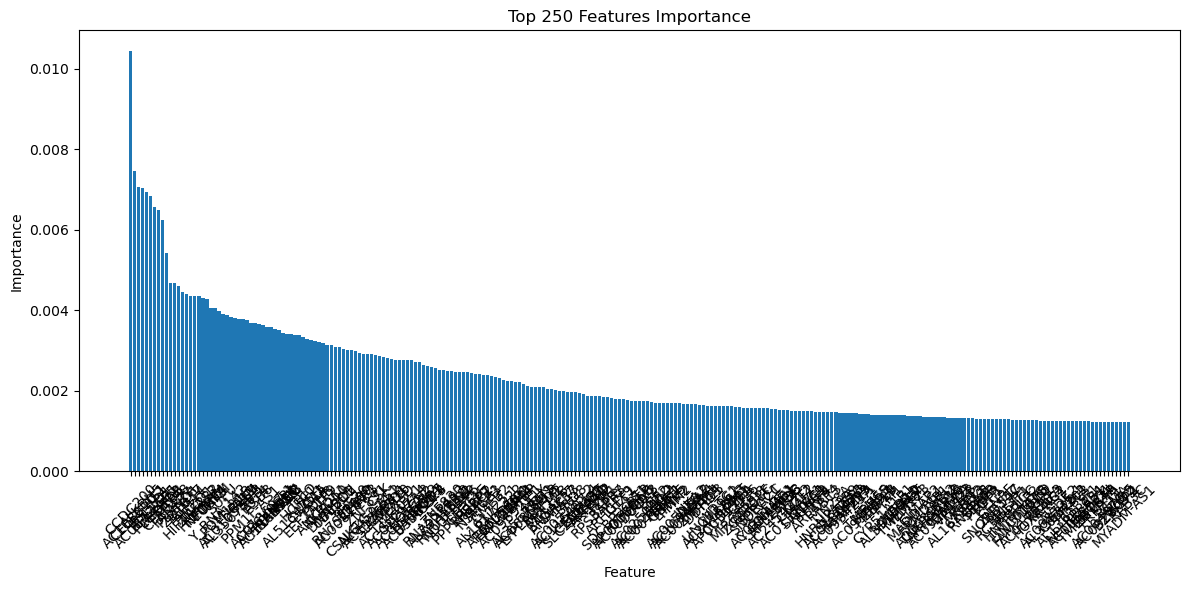

Last important feature:  1009


In [24]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [250]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [21]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset21/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [22]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset21/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset21/Feature_Select/results.csv", index=False)

Processing feature counts:   0%|          | 0/143 [00:00<?, ? feature counts/s]

Processing feature counts: 100%|██████████| 143/143 [06:04<00:00,  2.55s/ feature counts]


In [23]:
df = pd.read_csv("../Datasets/Dataset21/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0            ANN            140       0.8207 +/- 0.0338
1        XGBoost            133       0.8138 +/- 0.0560
2        XGBoost            134       0.8138 +/- 0.0560
3            ANN            130       0.8069 +/- 0.0560
4        XGBoost            135       0.8069 +/- 0.0516
5        XGBoost            132       0.8069 +/- 0.0468
6        XGBoost            131       0.8069 +/- 0.0468
7  Random Forest             22       0.8069 +/- 0.0352
8            ANN            139       0.8000 +/- 0.0961
9  Random Forest              5       0.8000 +/- 0.0736

### Check Distributions

In [25]:
feature_count = 140

data = pd.read_csv(
    f'../Datasets/Dataset21/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

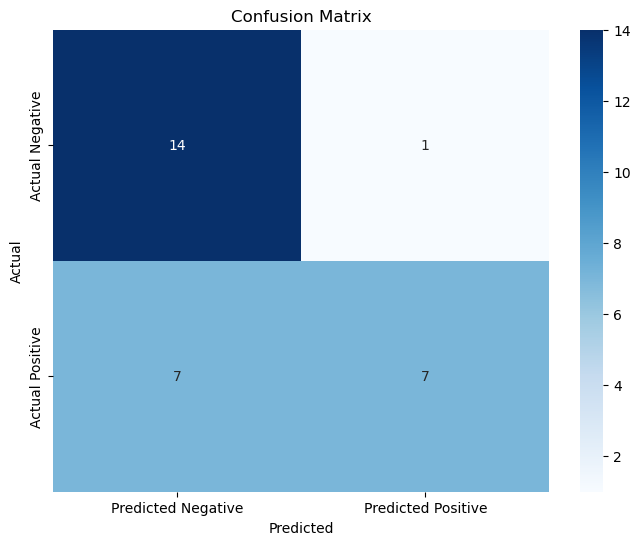

Accuracy: 0.72
Precision: 0.88
Recall (Sensitivity): 0.50
Specificity: 0.93
F1 Score: 0.64


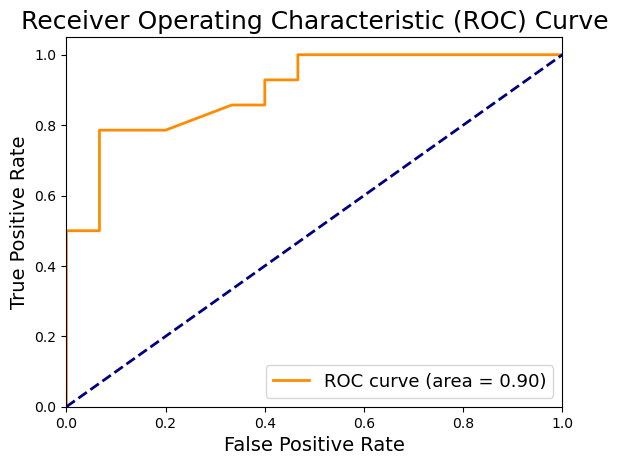

In [26]:
# feature_count = 43

df = pd.read_csv(
    f'../Datasets/Dataset21/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()